<a href="https://colab.research.google.com/github/KetrinIIII/Algorithms-for-massive-data-Project/blob/main/codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Project 4: Picture recognizer (Image Classification by Author)***

LIBRARIES

In [8]:
!pip install visualkeras
!pip install keras-tuner --upgrade

import tensorflow as tf
import visualkeras as vk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import keras_tuner as kt
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
from math import exp
from google.colab import userdata
import keras.backend as K
from keras.layers import Layer
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import mixed_precision
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    AveragePooling2D, BatchNormalization, ReLU, \
    Input, Add, Activation, Lambda, RandomFlip, \
    Rescaling, RandomContrast, RandomZoom, RandomRotation, Dropout

mixed_precision.set_global_policy('mixed_float16')

!rm -rf sample_data


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [9]:
import os
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = str(1)

In [10]:
device_name = tf.config.experimental.list_physical_devices('GPU')
if device_name:
    print("Found GPU at:", device_name[0].name)
    tf.config.experimental.set_memory_growth(device_name[0], True)
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


Kaggle API

Function to download images by author

Access the CSV file

In [3]:
import os
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxx"


In [5]:
!kaggle datasets download -d maparla/prado-museum-pictures


Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [03:55<00:00, 98.3MB/s]
100% 24.9G/24.9G [03:55<00:00, 114MB/s] 


In [6]:
!unzip /content/prado-museum-pictures.zip -d /content


Streaming output truncated to the last 5000 lines.
  inflating: /content/images/images/a00e794e-928d-40b7-b93d-25a717cbe928.jpg  
  inflating: /content/images/images/a01de9ba-e790-457d-8b08-0312bd49f8ee.jpg  
  inflating: /content/images/images/a0215d66-768d-4b08-9f45-5debe380e3cc.jpg  
  inflating: /content/images/images/a0234db3-6160-47ec-a62f-ae4585b30cfe.jpg  
  inflating: /content/images/images/a02862ca-52ef-4aeb-b1c2-0654954c8426.jpg  
  inflating: /content/images/images/a02a876e-f3fe-40a2-9ea9-8b25a5bda827.jpg  
  inflating: /content/images/images/a0324706-3b2b-49ca-8877-e7e031e5a487.jpg  
  inflating: /content/images/images/a034f244-a906-4d5b-9a13-299648fd4498.jpg  
  inflating: /content/images/images/a034f7c7-f71c-4a52-8f0d-5cd79d2f3c33.jpg  
  inflating: /content/images/images/a036ba7c-f04c-4c4c-892a-36137ba332b7.jpg  
  inflating: /content/images/images/a0416ffb-9003-4580-bcbd-e475c5a5c9fa.jpg  
  inflating: /content/images/images/a04b1ee5-2e98-4d4c-a6a1-82b56b104588.jpg  
 

In [11]:
import pandas as pd
df_path = '/content/prado.csv'
df = pd.read_csv(df_path)

In [12]:
df.shape

(13487, 30)

In [13]:
df['author'].value_counts()

,count
author,
Anónimo,2698
"Goya y Lucientes, Francisco de",1080
"Bayeu y Subías, Francisco",446
"Haes, Carlos de",326
"Pizarro y Librado, Cecilio",290
...,...
"Malombra, Pietro",1
"Taller de Bellini, Giovanni",1
"Mattioli, Ludovico -Dibujante- (Autor de la obra original: Cignani, Carlo)",1


Relevant authors

In [14]:
author_list = ['Goya y Lucientes, Francisco de', 'Bayeu y Subías, Francisco',
               'Haes, Carlos de', 'Pizarro y Librado, Cecilio']
df = df[df['author'].isin(author_list)]

Extract work_id

In [15]:
df['work_id'] = df['work_image_url'].apply(lambda x: x.split('/')[-1])


Define source and target directories

In [16]:
eng_authors = ['Goya', 'Bayeu', 'Haes', 'Pizarro']
esp_authors = ['Goya y Lucientes, Francisco de', 'Bayeu y Subías, Francisco',
               'Haes, Carlos de', 'Pizarro y Librado, Cecilio']

source_dir = '/content/images/images'
target_root_dir = '/content/data'

In [18]:
def download_images_by_author(esp_author, eng_author):

    df_filtered = df[df['author'] == esp_author]
    image_names = df_filtered['work_id'].tolist()

    target_dir = os.path.join(target_root_dir, eng_author)
    os.makedirs(target_dir, exist_ok=True)

    for image_name in image_names:
        source_path = os.path.join(source_dir, image_name)
        target_path = os.path.join(target_dir, image_name)

        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f'Warning: {source_path} does not exist.')


In [20]:
import shutil
for esp_author, eng_author in zip(esp_authors, eng_authors):
    download_images_by_author(esp_author, eng_author)

Function to count classes

In [21]:
def count_classes(dataset, class_names):
    class_counts = defaultdict(int)

    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1

    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    return class_counts

class_names = ['Goya', 'Bayeu', 'Haes', 'Pizarro']

Load training and validation datasets

In [22]:
def random_seeds_reset(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

random_seeds_reset()

DATADIR = "/content/data"
CLASS_NAMES = ['Goya', 'Bayeu', 'Haes', 'Pizarro']
IMG_SIZE = 224
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(CLASS_NAMES)

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATADIR,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    labels='inferred',
    class_names=CLASS_NAMES
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATADIR,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    labels='inferred',
    class_names=CLASS_NAMES
)

print("Class names:", CLASS_NAMES)

Found 2142 files belonging to 4 classes.
Using 1714 files for training.
Found 2142 files belonging to 4 classes.
Using 428 files for validation.
Class names: ['Goya', 'Bayeu', 'Haes', 'Pizarro']


In [23]:
count_classes(train_ds, class_names)

Goya: 880
Bayeu: 352
Haes: 259
Pizarro: 223


defaultdict(int, {'Goya': 880, 'Bayeu': 352, 'Haes': 259, 'Pizarro': 223})

In [24]:
count_classes(val_ds, class_names)

Pizarro: 67
Bayeu: 94
Haes: 67
Goya: 200


defaultdict(int, {'Pizarro': 67, 'Bayeu': 94, 'Haes': 67, 'Goya': 200})

Calculate class weights

In [25]:
num_samples_per_class = {name: 0 for name in CLASS_NAMES}

for _, labels in train_ds:
    for label in labels.numpy():
        class_name = CLASS_NAMES[label]
        num_samples_per_class[class_name] += 1

num_total = sum(num_samples_per_class.values())

class_weights = {
    i: round((1 / num_samples_per_class[CLASS_NAMES[i]]) * num_total, 2)
    for i in range(len(CLASS_NAMES))
}

print("Class Weights:", class_weights)


Class Weights: {0: 1.95, 1: 4.87, 2: 6.62, 3: 7.69}


Images from train data

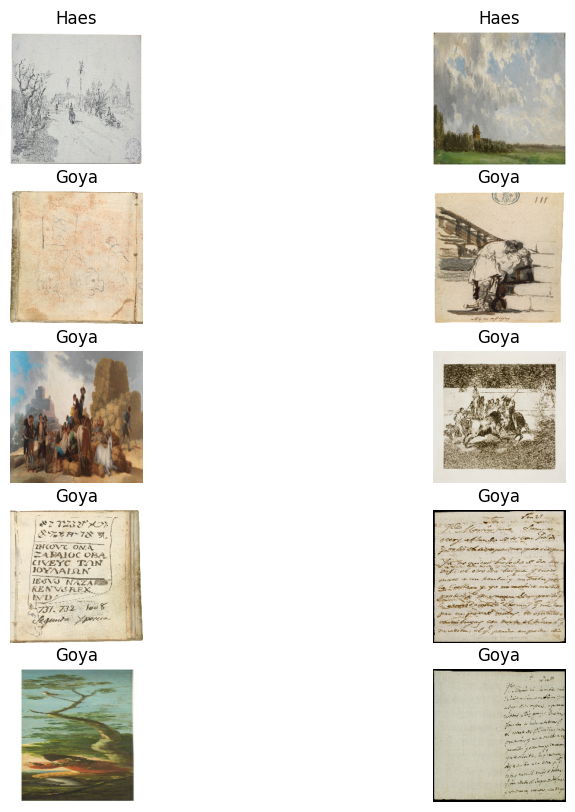

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis('off')

plt.show()

Images from validation data

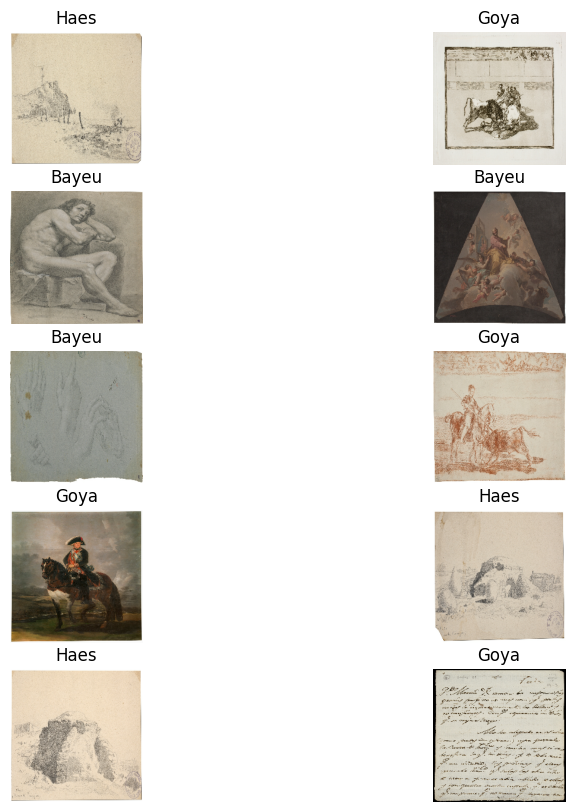

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis('off')

plt.show()

Plot training function

In [ ]:
def plot_function(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_acc, "go-", label='Training Accuracy')
    ax[0].plot(epochs, val_acc, "ro-", label='Validation Accuracy')
    ax[0].set_title('Training Accuracy & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(epochs, train_loss, "go-", label='Training Loss')
    ax[1].plot(epochs, val_loss, "ro-", label='Validation Loss')
    ax[1].set_title('Training Loss & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    plt.show()


Base model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_scaling (Rescaling)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 0.5674 - loss: 1.2516 - val_accuracy: 0.8481 - val_loss: 0.4448
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8225 - loss: 0.5137 - val_accuracy: 0.8879 - val_loss: 0.3847
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.8268 - loss: 0.4606 - val_accuracy: 0.8528 - val_loss: 0.3925
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8675 - loss: 0.3666 - val_accuracy: 0.9299 - val_loss: 0.2298
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9163 - loss: 0.2311 - val_accuracy: 0.9182 - val_loss: 0.2532
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9360 - loss: 0.2063 - val_accuracy: 0.9322 - val_loss: 0.2139
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9465 - loss: 0.1514 - val_accuracy: 0.9252 - val_loss: 0.2247
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9648 - loss: 0.1152 - val_accuracy: 0

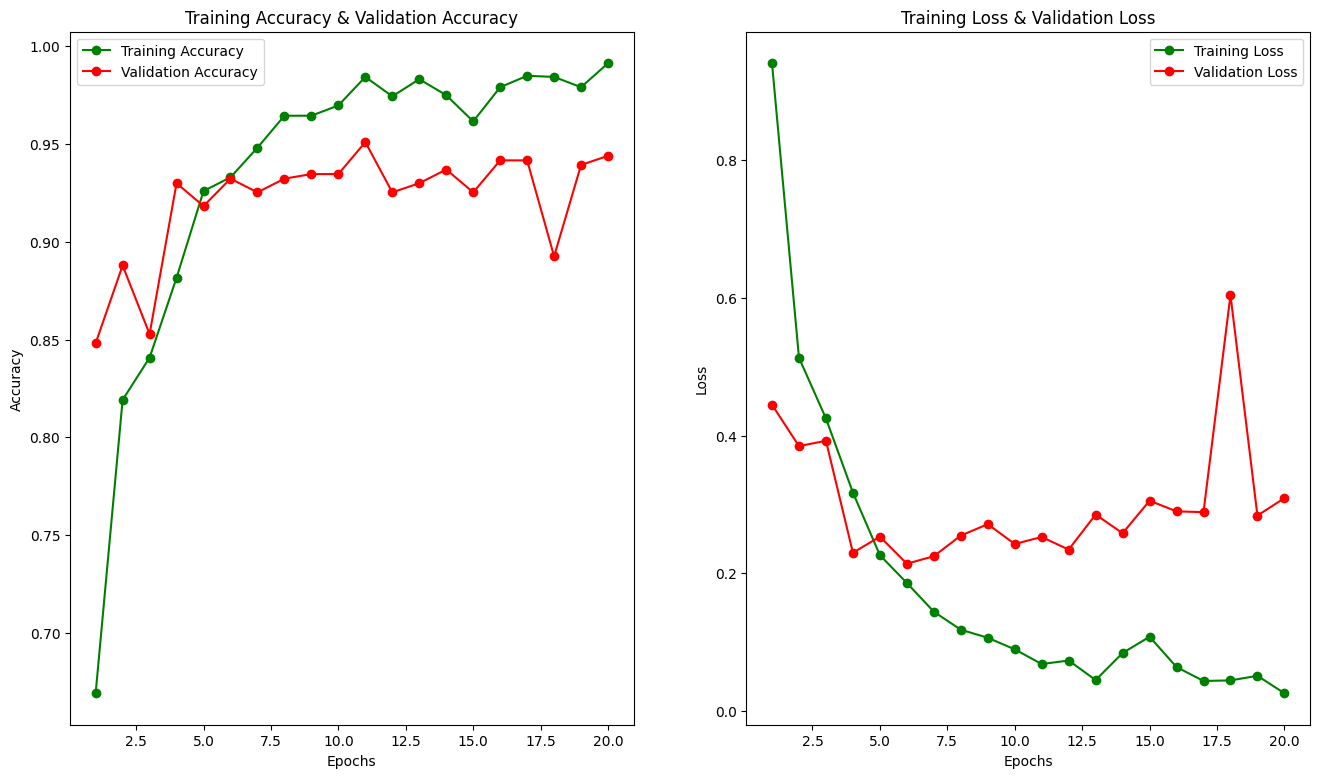

In [ ]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=input_shape, name='input_scaling'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, name='output_layer')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

model = build_model()

model.summary()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{IMG_SIZE}-model")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tensorboard_callback]
)

plot_function(history)

Data augmentation to the training dataset

In [ ]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=input_shape),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])
train_data = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize images to [0, 1]
train_data = train_ds.map(lambda x, y: (x / 255.0, y))
val_data = val_ds.map(lambda x, y: (x / 255.0, y))

# Caching, shuffling, and prefetching for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

print("Class names:", CLASS_NAMES)


Class names: ['Goya', 'Bayeu', 'Haes', 'Pizarro']


First model: three Convolutional and one Dense layer

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_scaling (Rescaling)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5172 - loss: 1.2964 - val_accuracy: 0.4673 - val_loss: 1.2724
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5014 - loss: 1.2273 - val_accuracy: 0.4673 - val_loss: 1.2098
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5126 - loss: 1.1390 - val_accuracy: 0.4673 - val_loss: 1.0193
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5306 - loss: 0.9701 - val_accuracy: 0.5958 - val_loss: 0.8258
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6332 - loss: 0.8500 - val_accuracy: 0.7079 - val_loss: 0.7280
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7203 - loss: 0.7268 - val_accuracy: 0.7734 - val_loss: 0.6221
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7161 - loss: 0.6911 - val_accuracy: 0.7967 - val_loss: 0.5795
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7590 - loss: 0.6424 - val_accuracy: 0.7967 - v

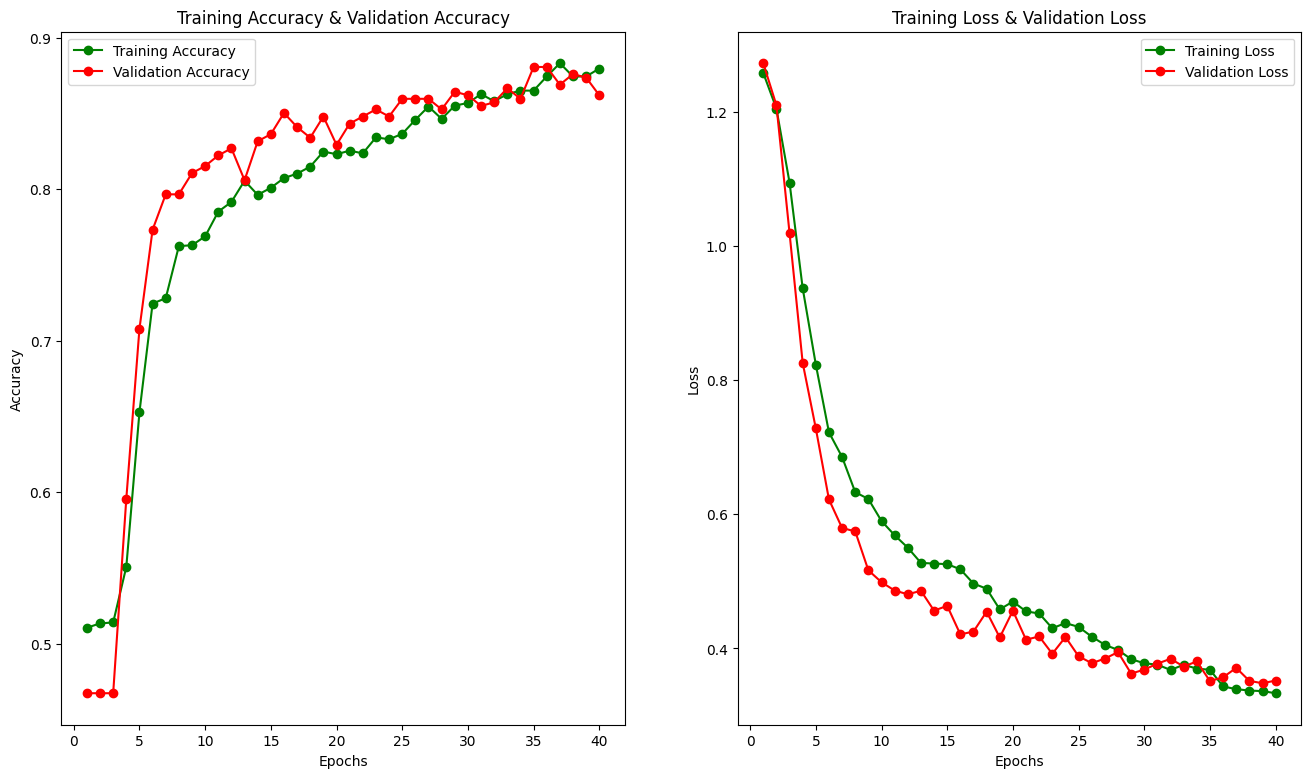

In [ ]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=input_shape, name='input_scaling'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),

        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, name='output_layer')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

model = build_model()

model.summary()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{IMG_SIZE}-model")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[tensorboard_callback]
)

plot_function(history)


Second Model: four Convolutitonal layers and one Dense layer

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_scaling (Rescaling)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,588 (25.98 MB)

 Trainable params: 6,811,588 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.4702 - loss: 1.2800 - val_accuracy: 0.4673 - val_loss: 1.3098
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5037 - loss: 1.2551 - val_accuracy: 0.4673 - val_loss: 1.2816
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5118 - loss: 1.2224 - val_accuracy: 0.4673 - val_loss: 1.1822
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4891 - loss: 1.1160 - val_accuracy: 0.5748 - val_loss: 0.9251
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6057 - loss: 0.9059 - val_accuracy: 0.7056 - val_loss: 0.8000
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7149 - loss: 0.7647 - val_accuracy: 0.8154 - val_loss: 0.6173
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7302 - loss: 0.6938 - val_accuracy: 0.8014 - val_loss: 0.5739
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7385 - loss: 0.6629 - val_accuracy: 0.8107 - v

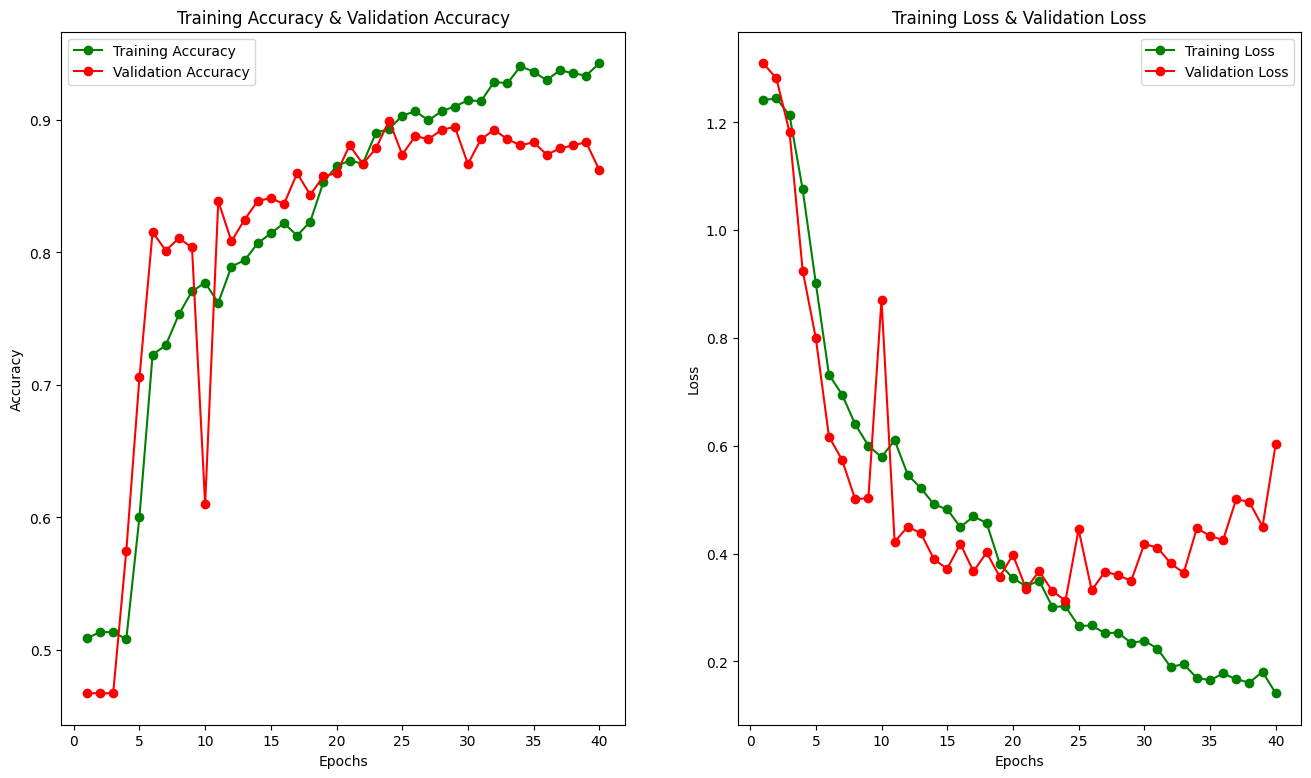

In [ ]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=input_shape, name='input_scaling'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
        layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv4'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool4'),

        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, name='output_layer')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

model = build_model()

model.summary()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{IMG_SIZE}-model")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[tensorboard_callback]
)
plot_function(history)


Third model: three Convolutional layers and two Dense layers

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_scaling (Rescaling)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,946,948 (49.39 MB)

 Trainable params: 12,946,948 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.4921 - loss: 1.3125 - val_accuracy: 0.4673 - val_loss: 1.2712
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5159 - loss: 1.2353 - val_accuracy: 0.4673 - val_loss: 1.2626
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4989 - loss: 1.2364 - val_accuracy: 0.4673 - val_loss: 1.2405
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5224 - loss: 1.2021 - val_accuracy: 0.4673 - val_loss: 1.1845
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5119 - loss: 1.1543 - val_accuracy: 0.4673 - val_loss: 1.0501
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5377 - loss: 1.0113 - val_accuracy: 0.4977 - val_loss: 0.9269
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5797 - loss: 0.9395 - val_accuracy: 0.6682 - val_loss: 0.8034
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6156 - loss: 0.8664 - val_accuracy: 0.7850 -

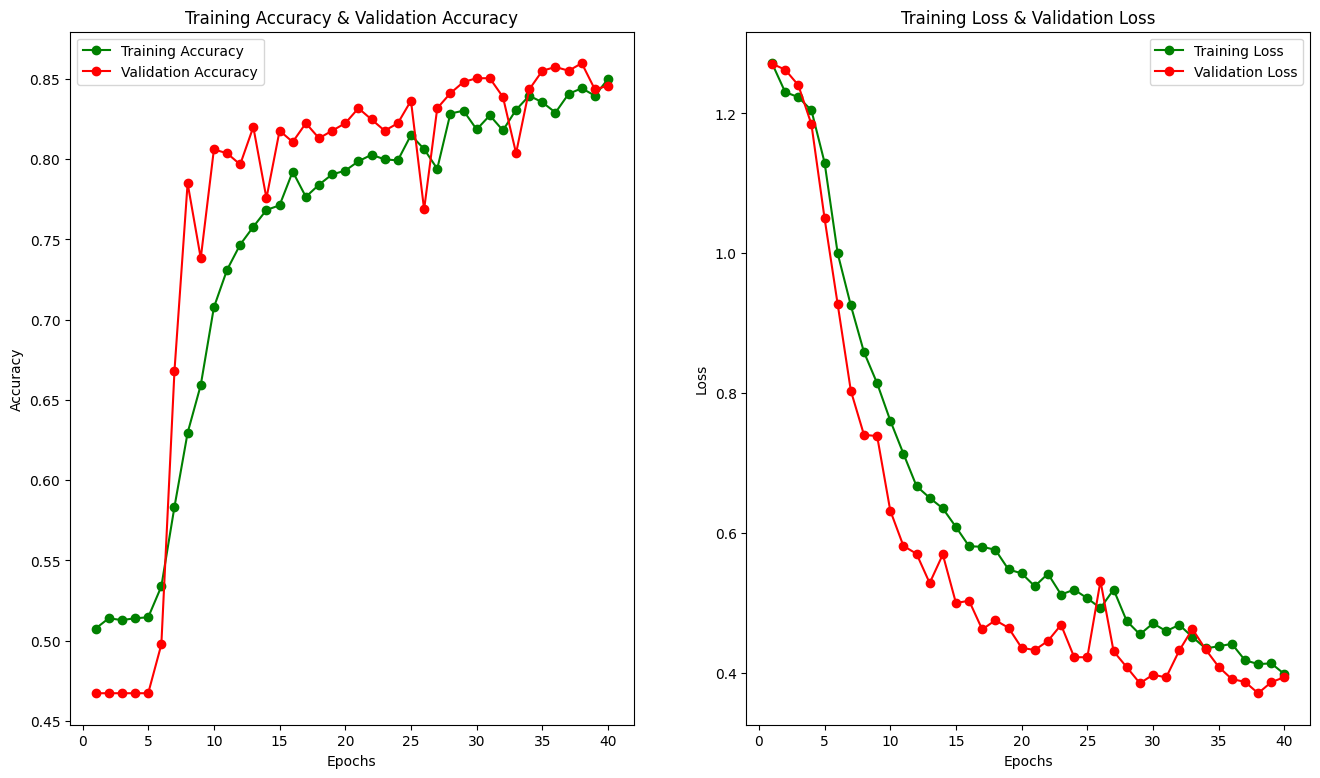

In [ ]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=input_shape, name='input_scaling'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),

        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(64, activation='relu', name='dense2'),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

model = build_model()

model.summary()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{IMG_SIZE}-model")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[tensorboard_callback]
)
plot_function(history)


Hyperparameter Tuning

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.2 MB/s eta 0:00:00


Early stopping callback for all tuning runs

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)



Tuning Convolutional Filters

In [ ]:
def tune_conv_filters(hp):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(hp.Choice('conv1_filters', [32, 64, 128]), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(hp.Choice('conv2_filters', [64, 128, 256]), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(hp.Choice('conv3_filters', [128, 256, 512]), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

conv_tuner = kt.RandomSearch(
    tune_conv_filters,
    objective='val_accuracy',
    max_trials=5,
    directory='conv_tuning',
    project_name='conv_filters_tuning'
)

conv_tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=[stop_early])
best_conv_filters = conv_tuner.get_best_hyperparameters()[0]


Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.4672897160053253

Best val_accuracy So Far: 0.836448609828949
Total elapsed time: 00h 01m 38s


In [ ]:
best_hps = conv_tuner.get_best_hyperparameters(num_trials=1)[0]

best_conv1_filters = best_hps.get('conv1_filters')
best_conv2_filters = best_hps.get('conv2_filters')
best_conv3_filters = best_hps.get('conv3_filters')

print("Best Conv1 Filters:", best_conv1_filters)
print("Best Conv2 Filters:", best_conv2_filters)
print("Best Conv3 Filters:", best_conv3_filters)


Best Conv1 Filters: 32
Best Conv2 Filters: 64
Best Conv3 Filters: 128


Dense units Tuning function

In [ ]:
def tune_dense_units(hp):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(best_conv1_filters, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv2_filters, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv3_filters, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(hp.Choice('dense_units', [128, 256, 512]), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

dense_tuner = kt.RandomSearch(
    tune_dense_units,
    objective='val_accuracy',
    max_trials=5,
    directory='dense_tuning',
    project_name='dense_units_tuning'
)

dense_tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=[stop_early])

best_dense_units = dense_tuner.get_best_hyperparameters()[0].get('dense_units')

print(f"Best dense units: {best_dense_units}")


Trial 3 Complete [00h 00m 23s]
val_accuracy: 0.735981285572052

Best val_accuracy So Far: 0.735981285572052
Total elapsed time: 00h 00m 53s
Best dense units: 512


Function to tune the Dropout rate

In [ ]:
def tune_dropout_rate(hp):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(best_conv_filters.get('conv1_filters'), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv_filters.get('conv2_filters'), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv_filters.get('conv3_filters'), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(best_dense_units, activation='relu'),

        layers.Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])),

        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

dropout_tuner = kt.RandomSearch(
    tune_dropout_rate,
    objective='val_accuracy',
    max_trials=3,
    directory='dropout_tuning',
    project_name='dropout_tuning'
)

dropout_tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=[stop_early])

best_dropout_rate = dropout_tuner.get_best_hyperparameters(num_trials=1)[0].get('dropout_rate')
print(f"Best dropout rate: {best_dropout_rate}")


Trial 3 Complete [00h 00m 15s]
val_accuracy: 0.4672897160053253

Best val_accuracy So Far: 0.8434579372406006
Total elapsed time: 00h 01m 07s
Best dropout rate: 0.3


Learning Rate Tuning function

In [ ]:
def tune_learning_rate(hp):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(best_conv_filters['conv1_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv_filters['conv2_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(best_conv_filters['conv3_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        layers.Dense(best_dense_units, activation='relu'),
        layers.Dropout(best_dropout_rate),

        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

lr_tuner = kt.RandomSearch(
    tune_learning_rate,
    objective='val_accuracy',
    max_trials=3,
    directory='learning_rate_tuning',
    project_name='learning_rate_tuning'
)

lr_tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=[stop_early])

best_learning_rate = lr_tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
print(f"Best learning rate: {best_learning_rate}")


Trial 3 Complete [00h 00m 15s]
val_accuracy: 0.4672897160053253

Best val_accuracy So Far: 0.8387850522994995
Total elapsed time: 00h 00m 57s
Best learning rate: 0.0001


Final model with tuned hyperparameters

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4934 - loss: 1.2826 - val_accuracy: 0.4673 - val_loss: 1.2583
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5201 - loss: 1.1947 - val_accuracy: 0.4673 - val_loss: 1.1709
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5096 - loss: 1.0988 - val_accuracy: 0.4977 - val_loss: 0.9243
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5821 - loss: 0.9013 - val_accuracy: 0.7710 - val_loss: 0.7329
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7246 - loss: 0.7513 - val_accuracy: 0.7523 - val_loss: 0.6356
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7560 - loss: 0.6620 - val_accuracy: 0.7991 - val_loss: 0.5722
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7759 - loss: 0.5943 - val_accuracy: 0.7710 - val_loss: 0.5726
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7629 - loss: 0.6045 - val_accuracy: 0.8107 - 

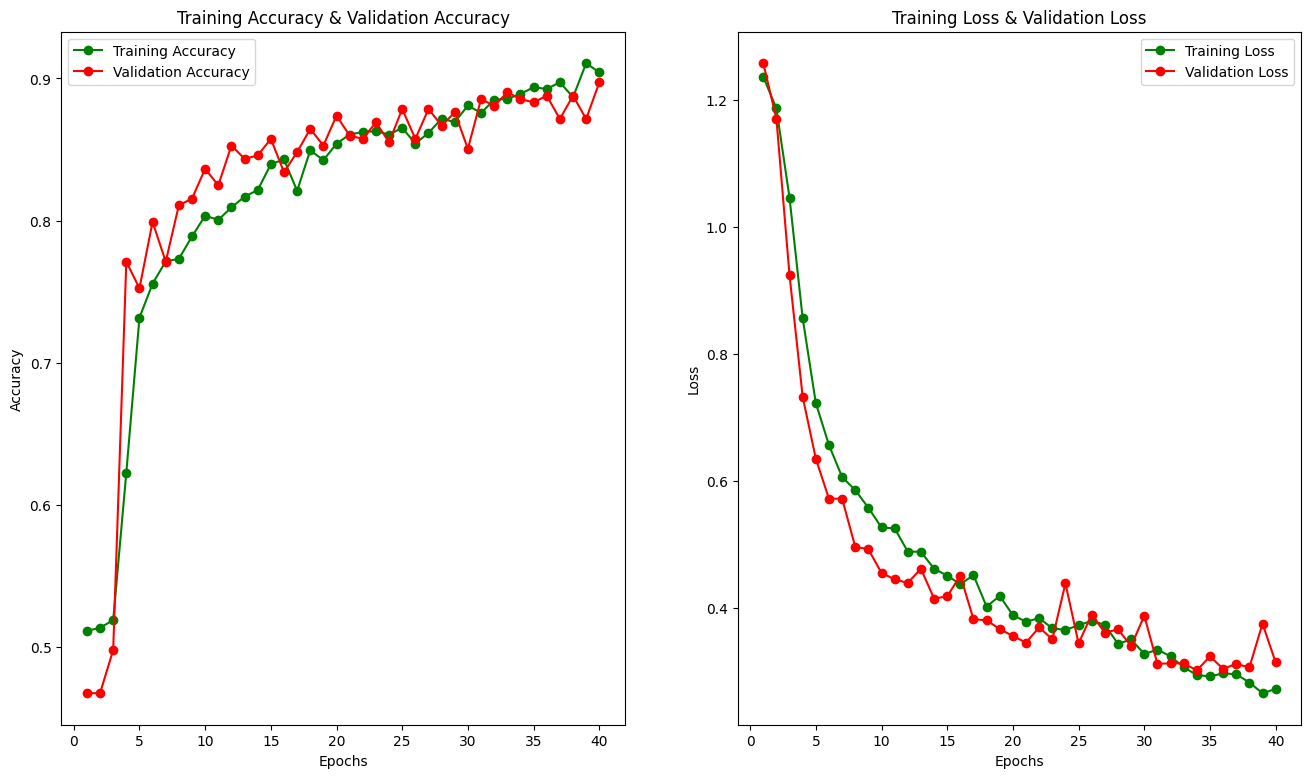

In [ ]:

final_model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(best_conv_filters['conv1_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(best_conv_filters['conv2_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(best_conv_filters['conv3_filters'], kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(best_dense_units, activation='relu'),
    layers.Dropout(best_dropout_rate),
    layers.Dense(num_classes)
])

final_model.compile(
    optimizer=Adam(learning_rate=best_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = final_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40
)
plot_function(history)


Confusion Matrix

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


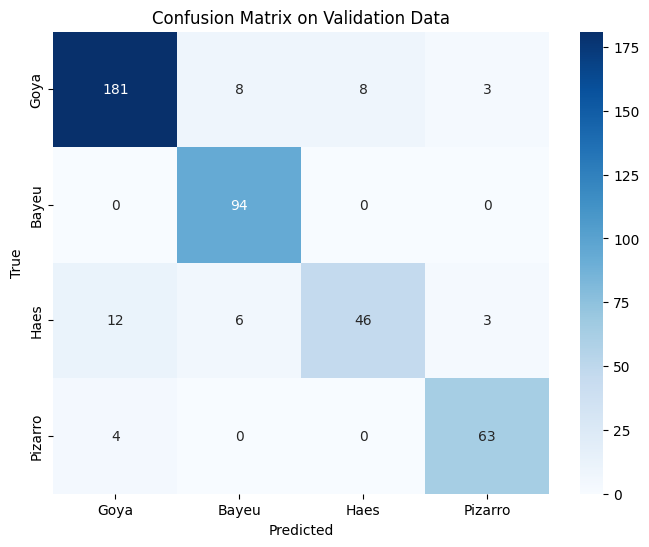

In [ ]:

y_pred = final_model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_data], axis=0)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()